# Using QSVT for Fixed-point Amplitude Amplification

This demo shows how to use the QSVT framework for search problems; specifically, implementing fixed-point amplitude amplification (FPAA). With FPAA, we do not know in advance the concentration of solutions for the search problem, but we want to sample a solution with high probability. In contrast, for the original Grover search algorithm, too many iterations might 'overshoot' the mark.

The demo is based on the paper [Grand unification of quantum algorithms](#grand).

Given $|s\rangle$ the initial state and $|t\rangle$ the 'good' states, we get an effective block encoding of a one-dimensional matrix $A=|t\rangle\langle s|$.

Given that  $a = \langle s|t\rangle\gt0$, we want to amplify $a$. The signal operator $U$ here is $I$ (and also $\dagger{U}$). Now we implement two projector-rotations: one in the '$|s\rangle$' space and one in the '$|t\rangle$' space; each one around the given state, giving phase to the specific state.

## Defining the QSVT Circuit for the Problem

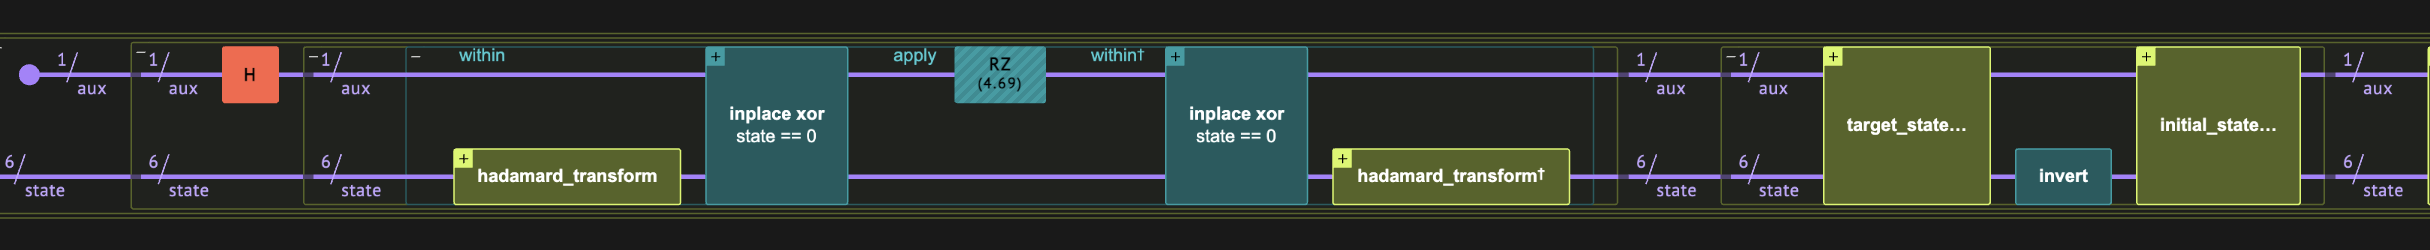

We start with the general QSVT framework definition. It accepts a unitary that block-encodes a matrix together with projector-controlled phase functions, which rotate the state around each of the subspaces where the matrix is encoded.

It applies the `qsvt_step` multiple times, iterating over the rotation angles provided that encode the polynomial transformation.

Note that the last step is quite tricky and depends on the specific transformation to perform. The code here is suitable for the FP Amplitude Amplification case. In addition, we wrap the auxilliary qubit with $H$ gates.

In [1]:
from classiq import *
from classiq.qmod.symbolic import floor, logical_and


@qfunc
def my_qsvt_step(
    phase1: CReal,
    phase2: CReal,
    proj_ctrl_phase_1: QCallable[CReal, QArray, QBit],
    proj_ctrl_phase_2: QCallable[CReal, QArray, QBit],
    u: QCallable[QArray],
    state: QArray,
    aux: QBit,
):
    u(state)
    proj_ctrl_phase_2(phase1, state, aux)
    invert(lambda: u(state))
    proj_ctrl_phase_1(phase2, state, aux)


@qfunc
def my_qsvt(
    phase_seq: CArray[CReal],
    proj_ctrl_phase_1: QCallable[CReal, QArray, QBit],
    proj_ctrl_phase_2: QCallable[CReal, QArray, QBit],
    u: QCallable[QArray],
    state: QArray,
    aux: QBit,
) -> None:
    H(aux)

    proj_ctrl_phase_1(phase_seq[0], state, aux)
    repeat(
        count=floor((phase_seq.len - 1) / 2),
        iteration=lambda index: my_qsvt_step(
            phase_seq[2 * index + 1],
            phase_seq[2 * index + 2],
            proj_ctrl_phase_1,
            proj_ctrl_phase_2,
            u,
            state,
            aux,
        ),
    )

    if_(
        condition=phase_seq.len % 2 == 1,
        then=lambda: IDENTITY(state),
        else_=lambda: (
            u(state),
            proj_ctrl_phase_2(
                phase_seq[phase_seq.len - 1],
                state,
                aux,
            ),
        ),
    )

    H(aux)

## Initial State z-rotation: Rotation Around $|s\rangle$

In [2]:
@qfunc
def initial_state_rot(phase: CReal, state: QNum, aux: QBit):
    within_apply(
        lambda: [hadamard_transform(state), inplace_xor(state == 0, aux)],
        lambda: RZ(phase, aux),
    )

## Good States z-rotation: Rotation Around $|t\rangle$

In [3]:
@qfunc
def target_state_rot(
    phase: CReal,
    arith_oracle: QCallable[QArray, QBit],
    state: QArray,
    aux: QBit,
):
    within_apply(lambda: arith_oracle(state, aux), lambda: RZ(phase, aux))

## Defining the Arithmetic Oracle

We implement the following equation: 
`(a + b) == 3 and (c - a) == 2`
with `a, b, c` in sizes 2, 1, 3:

In [4]:
class OracleVars(QStruct):
    a: QNum[2]
    b: QNum[1]
    c: QNum[3]


@qfunc
def arith_equation(state: OracleVars, res: QBit):
    res ^= logical_and((state.a + state.b) == 3, (state.c - state.a) == 2)

## Wrapping Everything for the FPAA Case

In the FPAA case, the provided unitary is just the Identity matrix! In addition, we provide both projector-controlled phase functions for the initial and target state rotations:

In [5]:
@qfunc
def qsvt_fpaa(
    phase_seq: CArray[CReal],
    arith_oracle: QCallable[Const[QArray], QBit],
    state: QArray,
    aux: Output[QBit],
):
    allocate(aux)

    my_qsvt(
        phase_seq,
        lambda phase, state, aux: initial_state_rot(phase, state, aux),
        lambda phase, state, aux: target_state_rot(phase, arith_oracle, state, aux),
        lambda state: IDENTITY(target=state),
        state,
        aux,
    )

## Getting the Phase Sequence for the Sign Function

We use the `pyqsp` package to receive the phases of the rotation sequence and get the coefficient of the sign function directly, based on the ERFC approximation:

In [6]:
import pyqsp

DEGREE = 25
X_BASIS = True

pg = pyqsp.poly.PolySign()
pcoefs, scale = pg.generate(
    degree=DEGREE,
    delta=10,
    ensure_bounded=True,
    return_scale=True,
    chebyshev_basis=True,
)

[pyqsp.poly.PolySign] degree=25, delta=10
[PolyTaylorSeries] (Cheb) max 0.8959971246530434 is at 1.0: normalizing
[PolyTaylorSeries] (Cheb) average error = 0.006320414386038567 in the domain [-1, 1] using degree 25


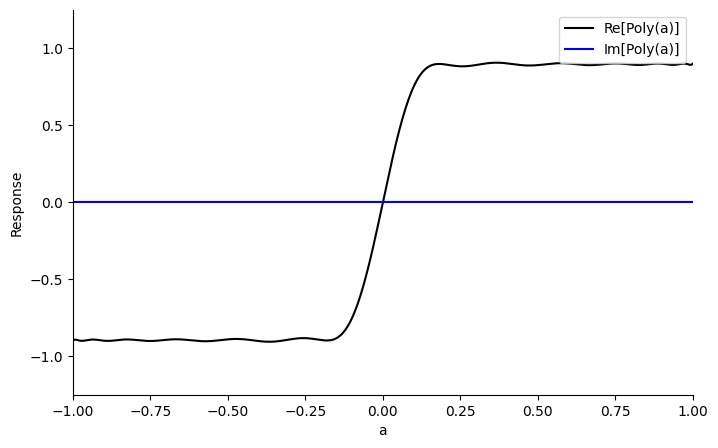

In [7]:
import numpy as np
from pyqsp.angle_sequence import Polynomial, QuantumSignalProcessingPhases

measurement = "x"
ang_seq = QuantumSignalProcessingPhases(
    pcoefs,
    signal_operator="Wx",
    method="laurent",
    measurement=measurement,
)
pyqsp.response.PlotQSPResponse(ang_seq, signal_operator="Wx", measurement=measurement)

The conventions by which the `pyqsp` package calculates the the phases are different from the phases we need for this QSVT circuit. The following block takes care of them.

As $R(a)=-i*e^{i\frac{\pi}{4}Z}W(a)e^{i\frac{\pi}{4}Z}$ and we have an odd number of rotations, we get an $i$ phase for our polynomial, so we get $Im(P(a))$ instead of the real part. So we get the result in the $|1\rangle$ state in the ancilla. However, we can fix it by adding an $\pi/2$ phase to the last or first rotation.

In [8]:
#### change the R(x) to W(x), as the phases are in the W(x) conventions
phases = np.array(ang_seq)
phases[1:-1] = phases[1:-1] - np.pi / 2
phases[0] = phases[0] - np.pi / 4
phases[-1] = phases[-1] + (2 * (len(phases) - 1) - 1) * np.pi / 4

phases = (
    -2 * phases
)  # verify conventions. minus is due to exp(-i*phi*z) in qsvt in comparison to qsp

## Creating the Full QSVT Model

In [9]:
@qfunc
def main(state: Output[OracleVars], aux: Output[QBit]):
    allocate(state)
    hadamard_transform(state)

    qsvt_fpaa(
        phase_seq=list(phases),
        arith_oracle=arith_equation,
        state=state,
        aux=aux,
    )

## Synthesizing and Executing on a Simulator

We use the Classiq synthesis engine to translate the model to a quantum circuit, and execute on the Classiq simulator:

In [10]:
write_qmod(main, "qsvt_fixed_point_amplitude_amplification")
qprog = synthesize(
    main,
    constraints=Constraints(max_width=12),
)

show(qprog)

Quantum program link: https://platform.classiq.io/circuit/2yfkICY08aitEnUo5HdC5GwT6g0


Execute the circuit:

In [11]:
result = execute(qprog).result_value()

In [12]:
def equation(a, b, c):
    return ((a + b) == 3) and ((c - a) == 2)


measured_good_shots = 0

for r in result.parsed_counts:
    a, b, c, aux = (
        r.state["state"]["a"],
        r.state["state"]["b"],
        r.state["state"]["c"],
        r.state["aux"],
    )
    if equation(a, b, c) and (aux == 0):
        print(
            f"a: {a}, b: {b}, c: {c}, aux: {aux}, equation_result: {equation(a, b, c)}, counts={r.shots}"
        )
        measured_good_shots += r.shots

print("Measured good shots:", measured_good_shots)

a: 3, b: 0, c: 5, aux: 0, equation_result: True, counts=857
a: 2, b: 1, c: 4, aux: 0, equation_result: True, counts=816
Measured good shots: 1673


What do we expect?

We need to substitute the amplitude of $|s\rangle\langle t|$ in $P(x)$:

In [17]:
poly_cheb = np.polynomial.Chebyshev(pcoefs)
p_good_shot = poly_cheb(np.sqrt(2 / 2**6)) ** 2
print("Expected good shots:", result.num_shots * p_good_shot)

Expected good shots: 1650.7688600460372


Indeed, we received the expected result according to the polynomial we created with the QSVT sequence:

In [16]:
import scipy

assert np.isclose(
    measured_good_shots,
    result.num_shots * p_good_shot,
    atol=5 * scipy.stats.binom.std(result.num_shots, p_good_shot),
)

## References

<a id='grand'>[1]</a>: [Martyn JM, Rossi ZM, Tan AK, Chuang IL. Grand unification of quantum algorithms. PRX Quantum. 2021 Dec 3;2(4):040203.](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.040203)
